In [1]:
import scipy.integrate as integ
import numpy as np
from tqdm.notebook import tqdm
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


EPSILON = 10 ** -6


def maximumFound(t, y, beta, gamma, n):
    s, i, r = y
    ds, di, dr = diff(0, y, beta, gamma, n)
    return ds * i + di * s


def diff(t, y, beta, gamma, n):
    s, i, r = y
    infs = beta * s * i / n
    recov = gamma * i
    return [-infs, infs - recov, recov]


def sim(beta, gamma, tmax, n):
    sol = integ.solve_ivp(diff, [0, tmax], [n-1, 1, 0],
                          args=(beta, gamma, n), dense_output=True,
                          events=maximumFound)

    t = sol.t
    y = sol.y
    try:
        tStar = sol.t_events[0][0]
    except:
        tStar = None

    return t, y, tStar


def runAll(betas, gammas, tmax, n):
    points = []
    for beta in betas:
        for gamma in gammas:
            points.append((beta, gamma))

    bornes = np.zeros((len(betas), len(gammas)))
    borneTab = []

    for i, point in enumerate(tqdm(points, smoothing=.01)):
        beta, gamma = point
        r0 = beta / gamma
        if r0 - 1 > EPSILON:
            t, y, tStar = sim(beta, gamma, tmax, n)
            if tStar is None:
                continue

            susceptibles = y[0]
            infected = y[1]
            recovered = y[2]

            iFunc = InterpolatedUnivariateSpline(t, infected, k=1)
            sFunc = InterpolatedUnivariateSpline(t, susceptibles, k=1)
            rFunc = InterpolatedUnivariateSpline(t, recovered, k=1)

            def nu(t):
                return beta * sFunc(t) * iFunc(t) / n

            result = integ.quad(lambda x: nu(x) \
                 * np.exp(-gamma * (x - tStar)), tStar, tmax, full_output=1)
            jStar = result[0]
            error = result[1]

            borne = r0 / n * np.abs(jStar - iFunc(tStar))

            if borne > 10:
                print(f'\nproblème: {beta} {gamma} {borne} {jStar} {error}')

            posi = i // len(gammas)
            posj = i % len(gammas)
            bornes[posi, posj] = borne
            borneTab.append(borne)
        else:
            borneTab.append(0)

    return points, betas, gammas, bornes, borneTab



In [2]:
min = .1
max = 10

points, betas, gammas, bornes, borneTab \
    = runAll(betas = np.arange(max, 0, - min),
             gammas = np.arange(min, max + min, min),
             tmax = 1000, n = 10**6)

# 1 minute for min = .25, max = 10
# 6 minutes for min = .1, max = 10

  0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\assim\AppData\Local\Temp\ipykernel_23588\929115365.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  plot = ax.contourf(betas, gammas, np.transpose(bornes),


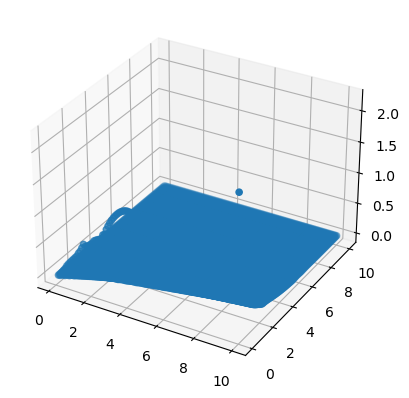

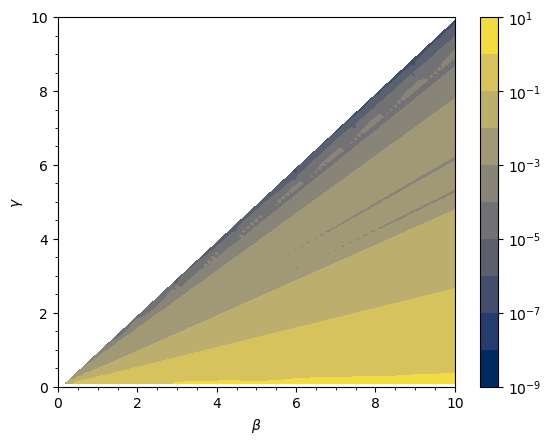

In [3]:
betaPoints = [x[0] for x in points]
gammaPoints = [x[1] for x in points]

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(betaPoints, gammaPoints, borneTab)

minP = int(np.min(np.floor(np.log10(bornes[bornes > 0]))))
maxP = int(np.max(np.ceil(np.log10(bornes[bornes > 0]))))

levels = [10**p for p in range(minP, maxP + 1)]


fmt1 = ticker.FuncFormatter(lambda value,pos: ("$10^{%d}$" % int(np.log10(value))))

fig, ax = plt.subplots()
plot = ax.contourf(betas, gammas, np.transpose(bornes),
                   levels=levels, locator=ticker.LogLocator(), cmap='cividis')
plt.xlabel('$\\beta$')
plt.ylabel('$\\gamma$')
plt.colorbar(plot, format=fmt1)
plt.xlim(left=0)
plt.ylim(bottom=0)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_major_formatter('{x:.0f}')

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(.5))

ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter('{x:.0f}')

# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(.5))

fig.savefig('contourError.png', bbox_inches='tight')

plt.show()


C:\Users\assim\AppData\Local\Temp\ipykernel_23588\1889640016.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


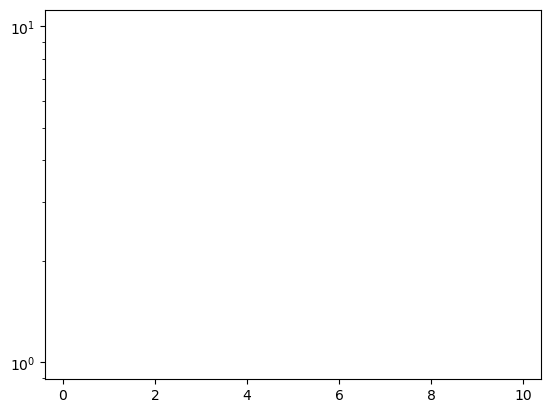

0.1 0.0
0.2 0.0
0.30000000000000004 0.0
0.4 0.0
0.5 0.0
0.6 0.0
0.7000000000000001 0.0
0.8 0.0
0.9 0.0
1.0 0.0
1.1 0.0
1.2000000000000002 0.0
1.3000000000000003 0.0
1.4000000000000001 0.0
1.5000000000000002 0.0
1.6 0.0
1.7000000000000002 0.0
1.8000000000000003 0.0
1.9000000000000001 0.0
2.0 0.0
2.1 0.0
2.2 0.0
2.3000000000000003 0.0
2.4000000000000004 0.0
2.5000000000000004 0.0
2.6 0.0
2.7 0.0
2.8000000000000003 0.0
2.9000000000000004 0.0
3.0000000000000004 0.0
3.1 0.0
3.2 0.0
3.3000000000000003 0.0
3.4000000000000004 0.0
3.5000000000000004 0.0
3.6 0.0
3.7 0.0
3.8000000000000003 0.0
3.9000000000000004 0.0
4.0 0.0
4.1 0.0
4.2 0.0
4.3 0.0
4.3999999999999995 0.0
4.5 0.0
4.6 0.0
4.7 0.0
4.8 0.0
4.9 0.0
5.0 0.0
5.1 0.0
5.2 0.0
5.3 0.0
5.4 0.0
5.5 0.0
5.6 0.0
5.7 0.0
5.8 0.0
5.9 0.0
6.0 0.0
6.1 0.0
6.2 0.0
6.3 0.0
6.4 0.0
6.5 0.0
6.6 0.0
6.7 0.0
6.8 0.0
6.9 0.0
7.0 0.0
7.1 0.0
7.2 0.0
7.3 0.0
7.4 0.0
7.5 0.0
7.6 0.0
7.7 0.0
7.8 0.0
7.9 0.0
8.0 0.0
8.1 0.0
8.2 0.0
8.3 0.0
8.4 0.0
8.5 0.0
8.6 

In [4]:
betaPoints = [x[0] for x in points]
gammaPoints = [x[1] for x in points]

plt.plot(gammas[:-1], np.transpose(bornes)[:, -1][:-1])
plt.yscale('log')
plt.show()

# InterpolatedUnivariateSpline(gammaPoints, bornes[])

for i, x in enumerate(np.transpose(bornes)[:, -1]):
    print(gammas[i], x)